In [15]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
import squidpy as sq
from skimage import io
from tqdm.notebook import tqdm, trange

sc.settings.verbosity = 3

import matplotlib
from matplotlib import cm, colors
from matplotlib.pyplot import rc_context

sc.set_figure_params(format="png")
import anndata as ad
import seaborn as sns
from kneed import KneeLocator
from matplotlib.ticker import MaxNLocator
from PIL import Image
from scipy import ndimage
from skimage import exposure, measure, morphology
from sklearn.cluster import MiniBatchKMeans
import napari
import math


In [16]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [17]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
all_donor = ["TS Donor A", "TS Donor E"]


# Read follicle 

In [19]:
dfs = []

for donor in all_donor:
    path = data_dir / 'metadata' / f'follicle_{donor}.csv'
    df = pd.read_csv(path)
    dfs.append(df.iloc[:,1:])
    
df_all = pd.concat(dfs)

In [20]:
df_intensity = df_all.drop(['X', 'Y', 'Major axis projection', 'Minor axis projection'], axis=1)

In [21]:
df_intensity_mean = df_intensity.groupby(['ROI', 'follicle']).mean()

In [22]:
df_intensity_mean.reset_index(inplace=True)

In [23]:
adata = ad.AnnData(df_intensity_mean.iloc[:,2:])
adata.var_names = df_intensity_mean.iloc[:,2:].columns.tolist()
adata.obs['ROI'] = df_intensity_mean['ROI'].tolist()
adata.obs['Follicle'] = df_intensity_mean['follicle'].tolist()

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [24]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'ROI' as categorical


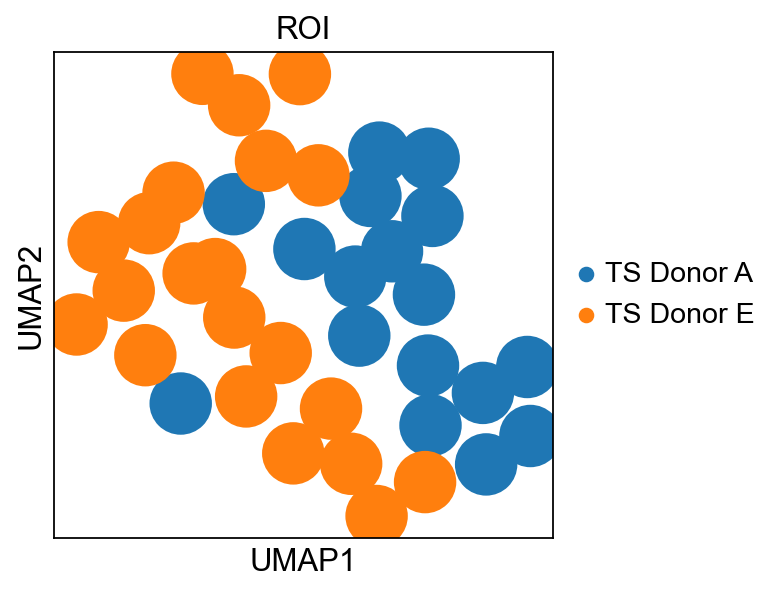

In [25]:
sc.pl.umap(adata, color='ROI')

In [26]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
labels = le.fit_transform(df_intensity_mean['ROI'].tolist())

In [27]:
X_umap = adata.obsm['X_umap']

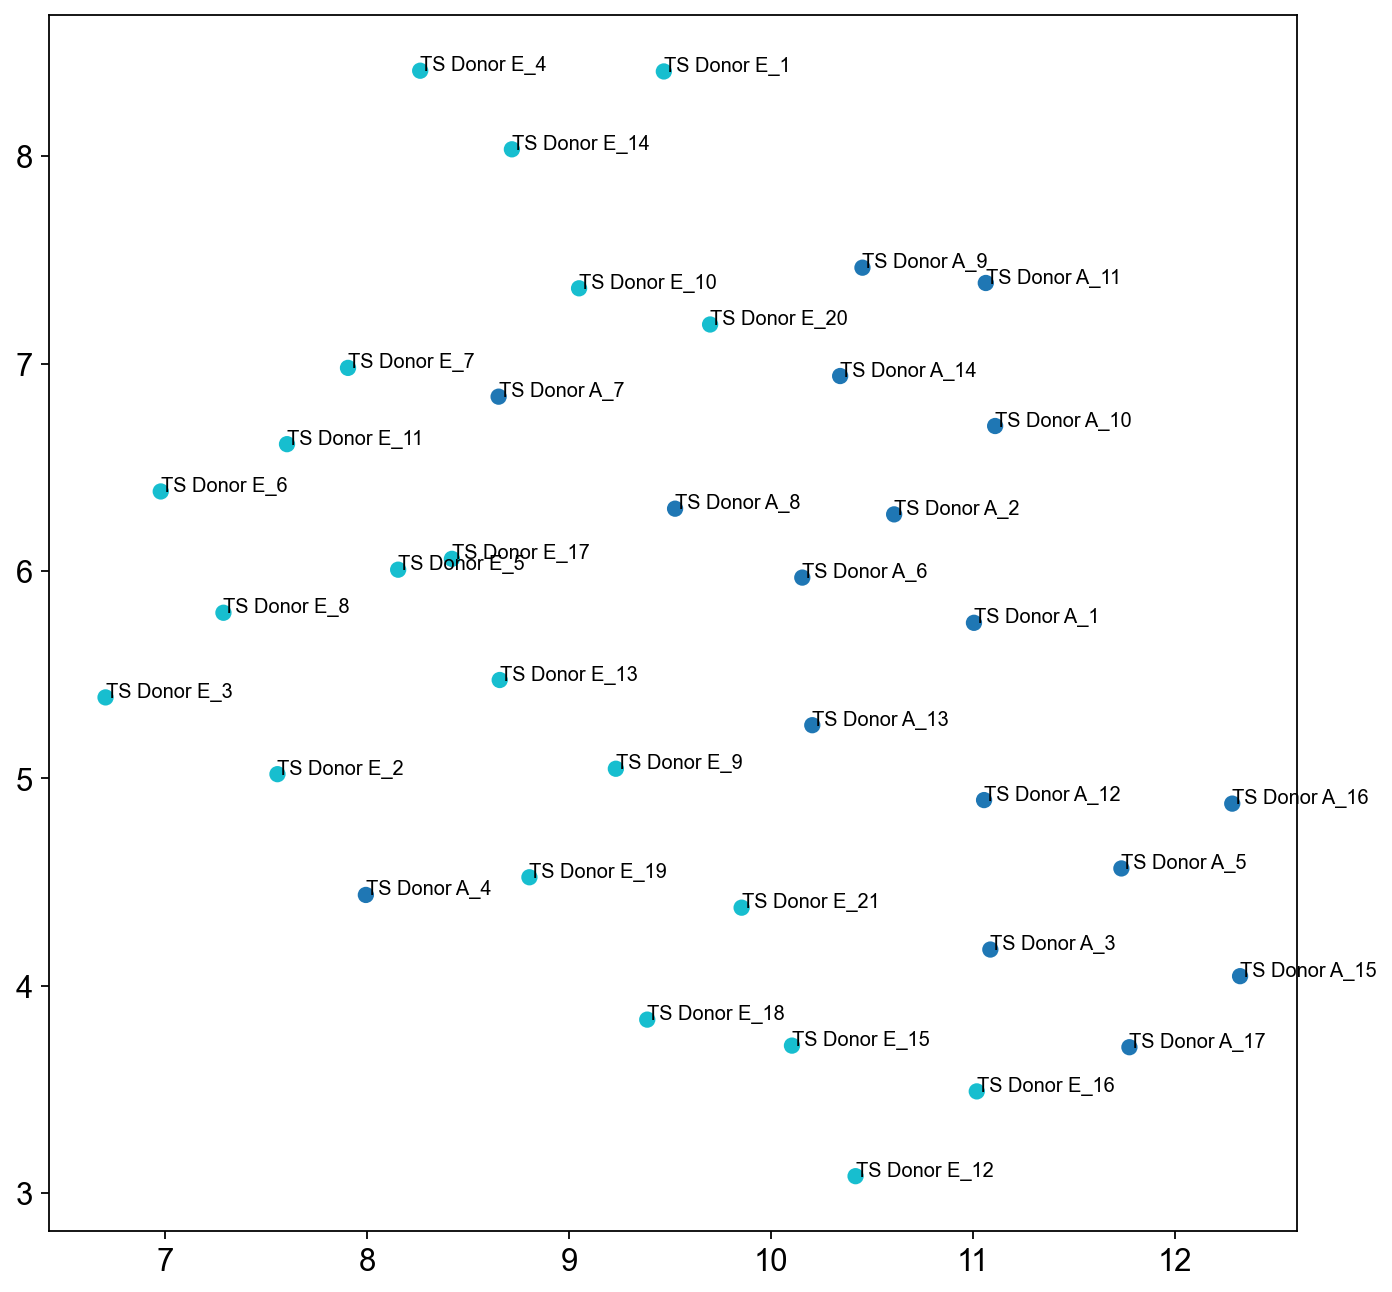

In [32]:
rois = df_intensity_mean['ROI'].tolist()
follicles = df_intensity_mean['follicle'].tolist()

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_umap[:,0], X_umap[:,1], c=labels, s=40, cmap='tab10')
for i in range(len(rois)):
    txt = f'{rois[i]}_{follicles[i]}'
    ax.annotate(txt, (X_umap[i,0], X_umap[i,1]), fontsize=9)
ax.grid(False)